### **Import Library**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile, os, random
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report
import itertools

from google.colab import drive
from PIL import Image

### **Import Datatset dari Google Drive dan Ekstraksi Dataset**

In [ ]:
drive.mount('/content/drive')
path_to_dataset = '/content/drive/My Drive/dataset/dataset_daun.zip'

zip_file = path_to_dataset
extract_folder = "images"

if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Ekstrak file zip
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("File zip telah berhasil diekstrak.")

Mounted at /content/drive
File zip telah berhasil diekstrak.


### **Tahap Preprocessing - Resize Data**

In [ ]:
BASE_DIR = '/content/images/dataset_daun/'

batch_size = 32
img_size = (224,224)

train_dataset = image_dataset_from_directory(
    BASE_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)
val_dataset = image_dataset_from_directory(
    BASE_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_dataset.class_names

Found 960 files belonging to 8 classes.
Using 768 files for training.
Found 960 files belonging to 8 classes.
Using 192 files for validation.


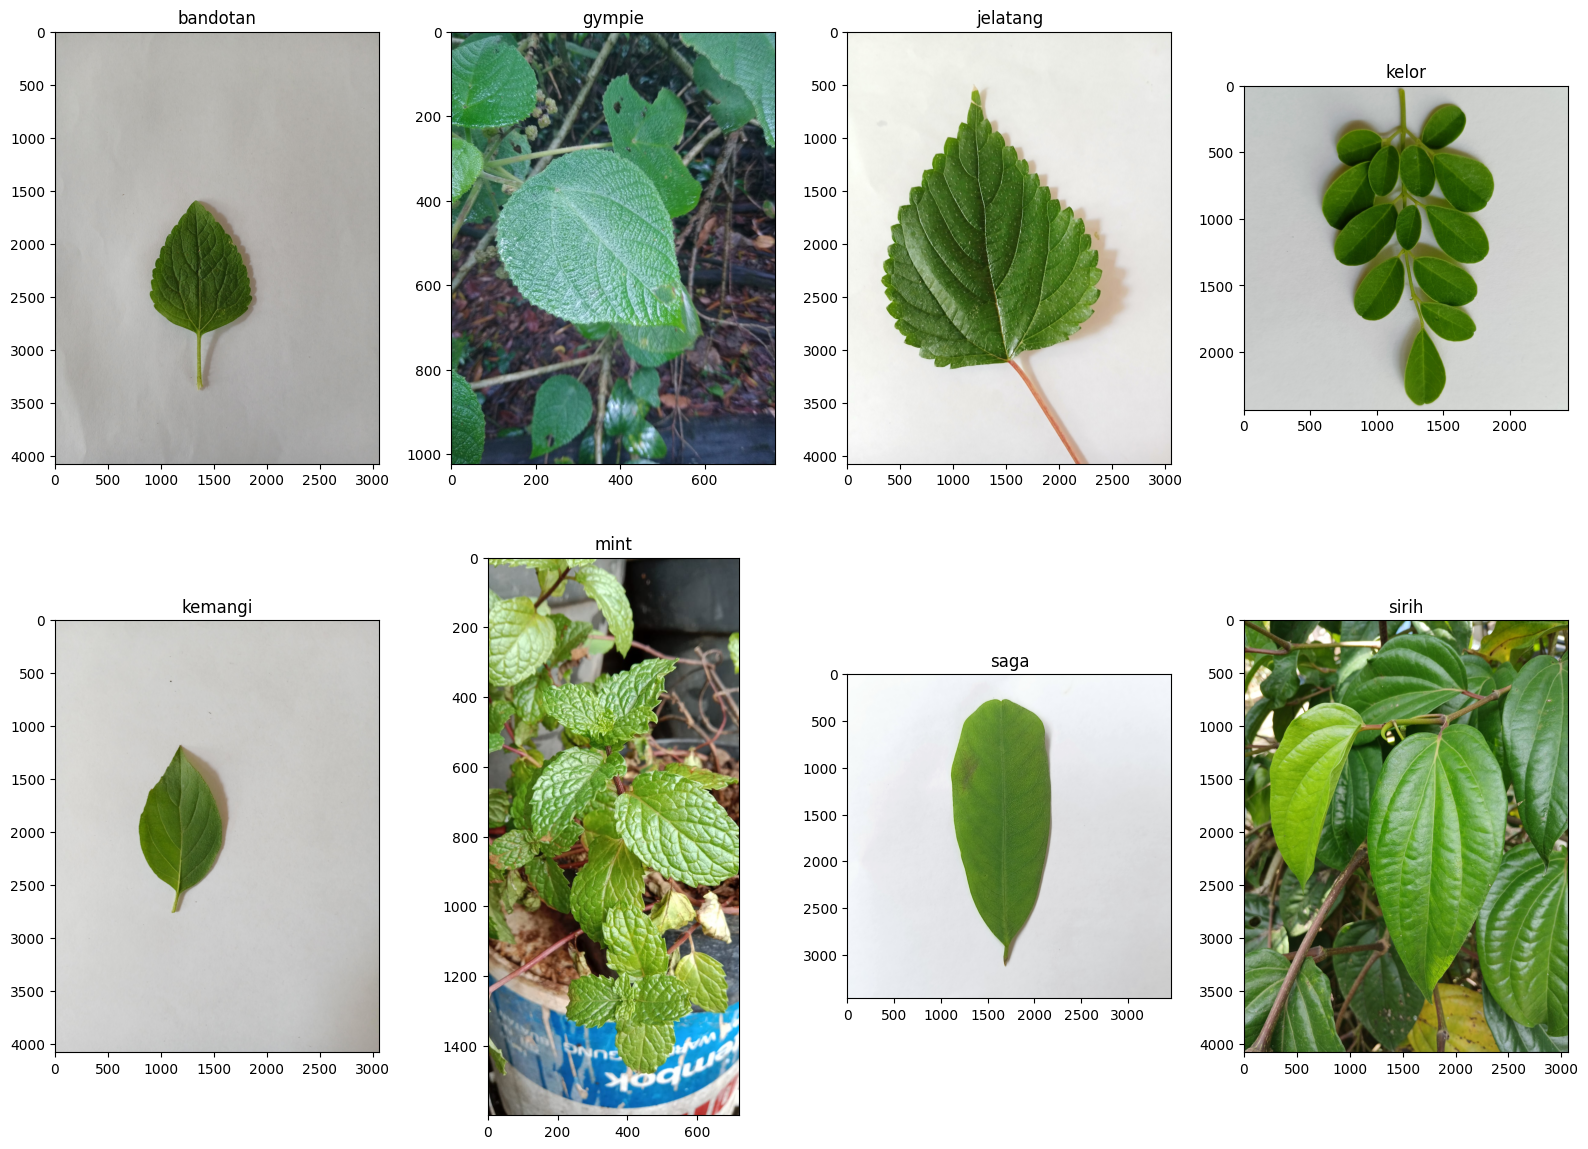

In [ ]:
# Visualisasi Sampel Data
plt.figure(figsize=(16, 12))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(BASE_DIR, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    image = Image.open(image_path)
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    # plt.axis("off")
plt.tight_layout()
plt.show()

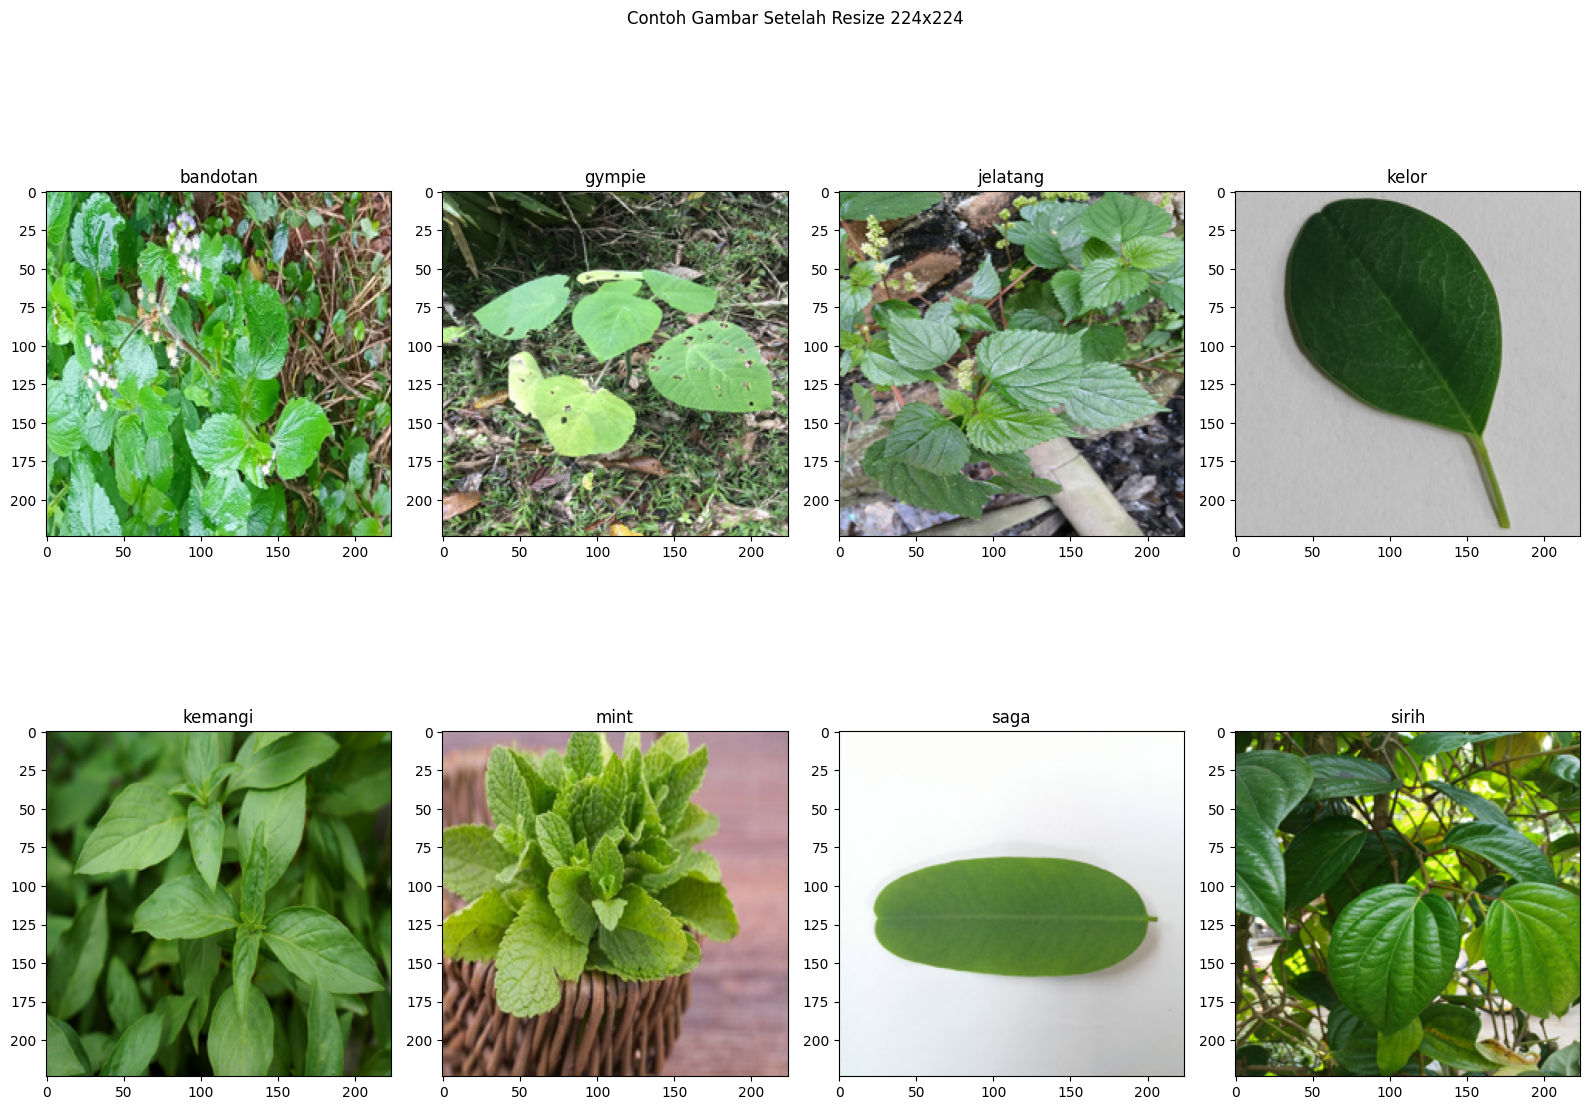

In [ ]:
# Visualisasi Resize Data
plt.figure(figsize=(16, 12))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(BASE_DIR, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    resized_image = Image.open(image_path).resize(img_size)
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(resized_image)
    plt.title(class_name)
    # plt.axis("off")
plt.tight_layout()
plt.suptitle("Contoh Gambar Setelah Resize 224x224", y=1.02)
plt.show()

Jumlah Data per Kelas:
Kelas           Train      Validasi  
-----------------------------------
bandotan        93         27        
gympie          98         22        
jelatang        100        20        
kelor           93         27        
kemangi         94         26        
mint            100        20        
saga            89         31        
sirih           101        19        


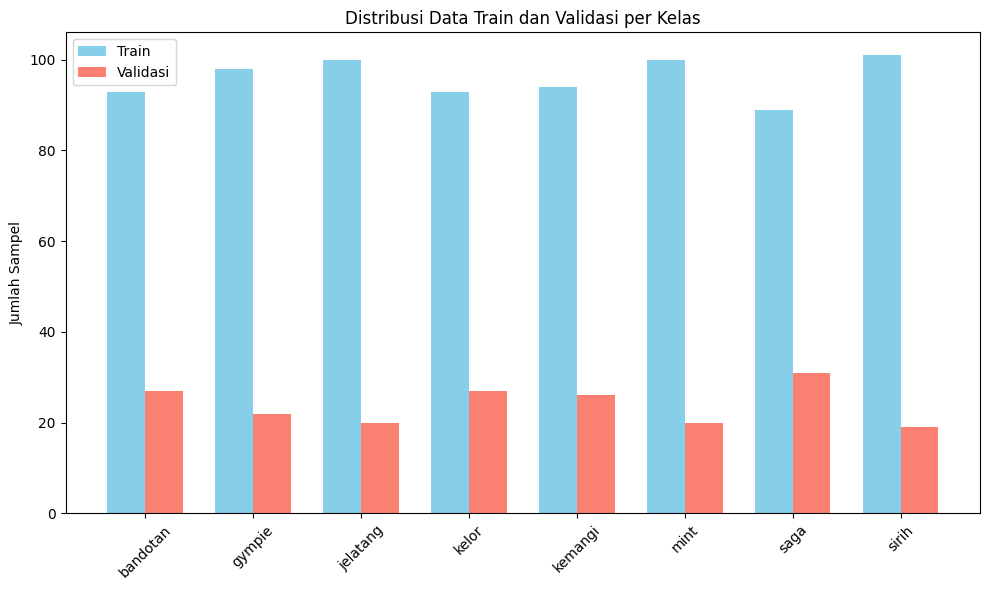

In [ ]:
from collections import Counter

def count_class_distribution(dataset):
    label_counter = Counter()
    for _, labels in dataset.unbatch():
        index = np.argmax(labels.numpy())
        label_counter[index] += 1
    return label_counter

# Hitung jumlah label
train_counts = count_class_distribution(train_dataset)
val_counts = count_class_distribution(val_dataset)

# Format hasil
print("Jumlah Data per Kelas:")
print("{:<15} {:<10} {:<10}".format("Kelas", "Train", "Validasi"))
print("-" * 35)
for i, class_name in enumerate(class_names):
    print("{:<15} {:<10} {:<10}".format(
        class_name,
        train_counts.get(i, 0),
        val_counts.get(i, 0)
    ))

# Visualisasi
x = np.arange(len(class_names))
width = 0.35
train_vals = [train_counts.get(i, 0) for i in range(len(class_names))]
val_vals = [val_counts.get(i, 0) for i in range(len(class_names))]

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_vals, width, label='Train', color='skyblue')
plt.bar(x + width/2, val_vals, width, label='Validasi', color='salmon')
plt.xticks(x, class_names, rotation=45)
plt.ylabel("Jumlah Sampel")
plt.title("Distribusi Data Train dan Validasi per Kelas")
plt.legend()
plt.tight_layout()
plt.show()

### **Tahap Preprocessing - Augmentasi Data**

In [ ]:
# Advanced Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.1)
])

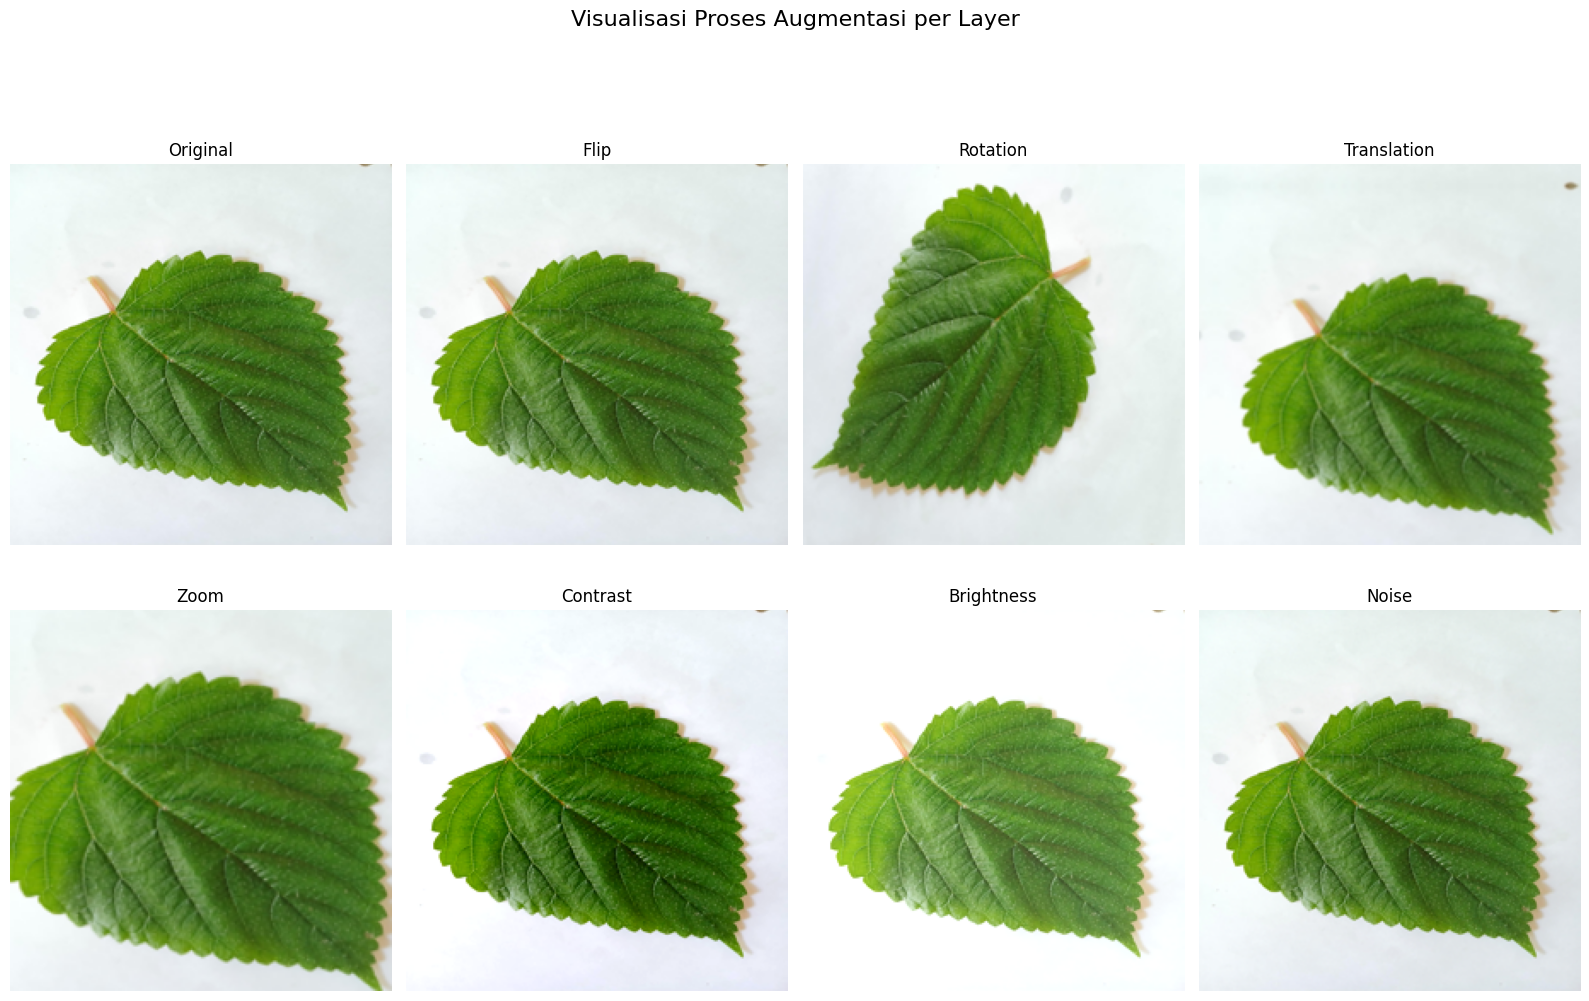

In [ ]:
# Visualisasi Augmentasi
sample_class = random.choice(class_names)
sample_path = os.path.join(BASE_DIR, sample_class, random.choice(os.listdir(os.path.join(BASE_DIR, sample_class))))
original_img = Image.open(sample_path).resize(img_size)
img_array = tf.keras.preprocessing.image.img_to_array(original_img)
img_array = tf.expand_dims(img_array, 0)

# Daftar layer
augmentations = [
    ("Flip", layers.RandomFlip("horizontal")),
    ("Rotation", layers.RandomRotation(0.3)),
    ("Translation", layers.RandomTranslation(0.1, 0.1)),
    ("Zoom", layers.RandomZoom(0.2)),
    ("Contrast", layers.RandomContrast(0.2)),
    ("Brightness", layers.RandomBrightness(0.2)),
    ("Noise", layers.GaussianNoise(0.1))
]

plt.figure(figsize=(16, 10))
plt.subplot(2, 4, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis("off")

for i, (title, layer) in enumerate(augmentations):
    aug_model = tf.keras.Sequential([layer])
    aug_image = aug_model(img_array, training=True)[0].numpy().astype("uint8")
    plt.subplot(2, 4, i + 2)
    plt.imshow(aug_image)
    plt.title(title)
    plt.axis("off")

plt.suptitle("Visualisasi Proses Augmentasi per Layer", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


### **Arsitektur Model CNN**

In [ ]:
# Arsitektur Model CNN
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_20 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,267,400 (73.50 MB)

 Trainable params: 19,267,400 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

### **Compile dan Training Model**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callback_list = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.3, patience=5, verbose=1)
]

# Training Model
history = model.fit(
    train_dataset.cache().prefetch(tf.data.AUTOTUNE),
    validation_data=val_dataset.cache().prefetch(tf.data.AUTOTUNE),
    epochs=100,
    callbacks=callback_list,
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1490 - loss: 2.4963 - val_accuracy: 0.2812 - val_loss: 1.8997 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3021 - loss: 1.8176 - val_accuracy: 0.2292 - val_loss: 1.5961 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3532 - loss: 1.5682 - val_accuracy: 0.4115 - val_loss: 1.4606 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.3659 - loss: 1.5682 - val_accuracy: 0.4375 - val_loss: 1.2914 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.4107 - loss: 1.4809 - val_accuracy: 0.5000 - val_loss: 1.2289 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3800 - loss: 1.4805 - val_accuracy: 0.5260 - val_loss: 1.2428 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.4476 - loss: 1.3117 - v

### **Download Model**

In [ ]:
model.save('Model_32.keras')
print("Model berhasil disimpan")

Model berhasil disimpan


In [ ]:
import json

with open('History_Model_32.json', 'w') as f:
    json.dump(history.history, f)


### **Plot Untuk Akurasi dan Loss Model**

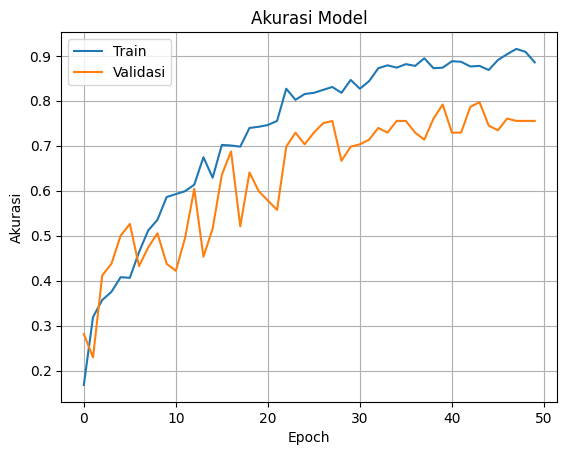

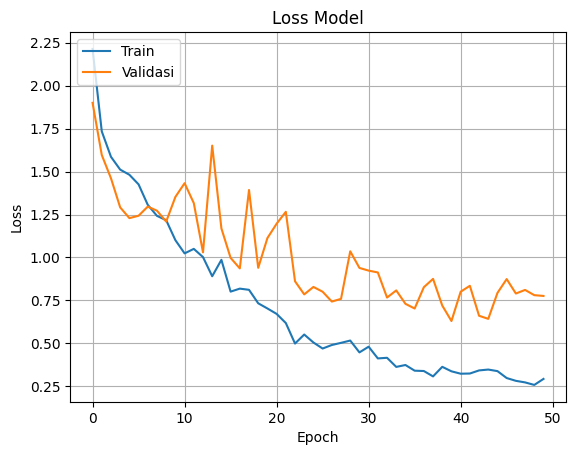

In [ ]:
# Plot Akurasi dan Loss
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validasi'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validasi'], loc='upper left')
plt.grid(True)
plt.show()

### **Proses Evaluasi pada Data Testing dengan Confusion Matrix**

Confusion matrix, without normalization


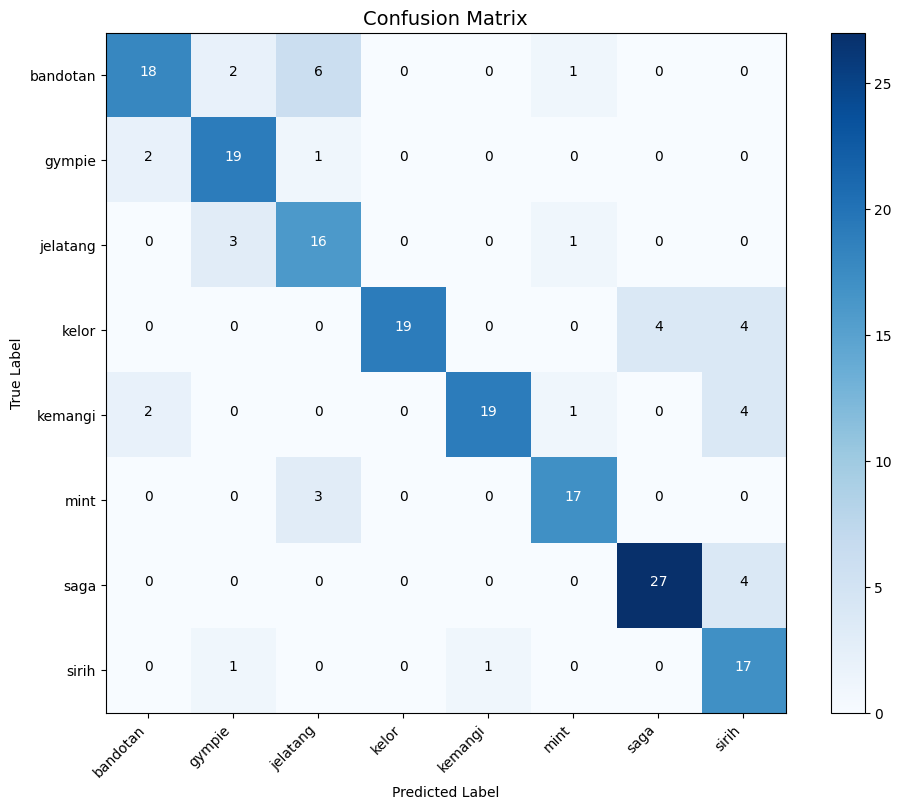

Normalized confusion matrix


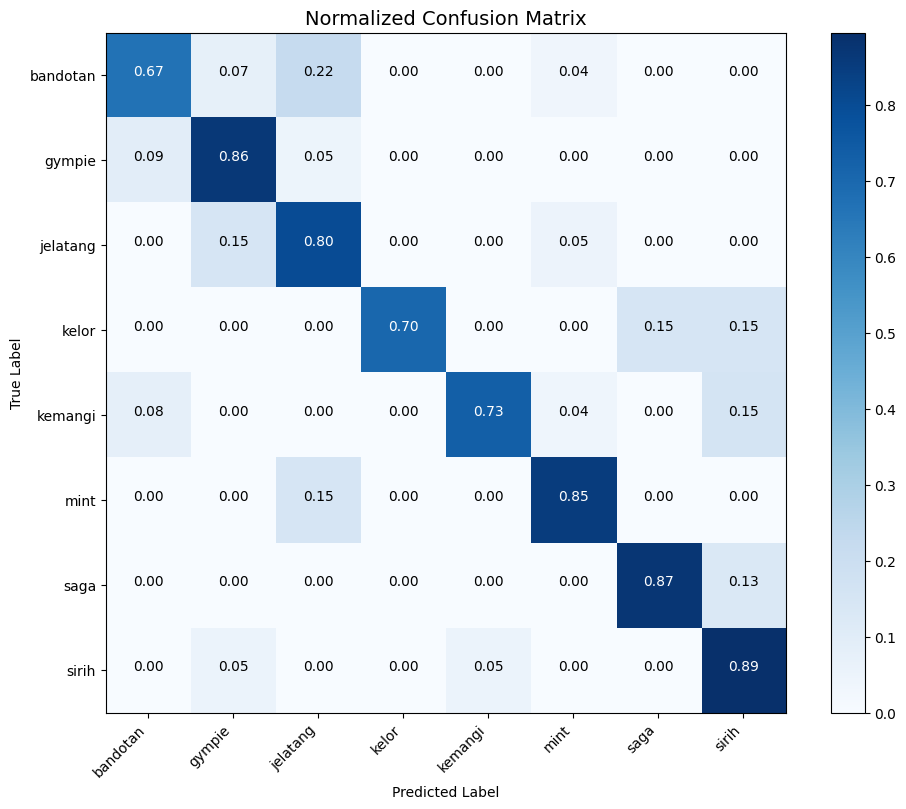


Classification Report:

              precision    recall  f1-score   support

    bandotan       0.82      0.67      0.73        27
      gympie       0.76      0.86      0.81        22
    jelatang       0.62      0.80      0.70        20
       kelor       1.00      0.70      0.83        27
     kemangi       0.95      0.73      0.83        26
        mint       0.85      0.85      0.85        20
        saga       0.87      0.87      0.87        31
       sirih       0.59      0.89      0.71        19

    accuracy                           0.79       192
   macro avg       0.81      0.80      0.79       192
weighted avg       0.82      0.79      0.80       192



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Evaluasi dengan Confusion Matrix
y_pred, y_true = [], []
val_dataset_reset = val_dataset.unbatch().batch(1)

for images, labels in val_dataset_reset:
    pred = model.predict(images, verbose=0)
    y_pred.append(np.argmax(pred, axis=1)[0])
    y_true.append(np.argmax(labels.numpy(), axis=1)[0])

# Hitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Fungsi untuk menampilkan confusion matrix (termasuk normalisasi yang benar)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, class_names, title='Confusion Matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(confusion_mtx, class_names, normalize=True, title='Normalized Confusion Matrix')

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
